# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94739 entries, 0 to 94738
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                94739 non-null  object 
 1   unique_id               94739 non-null  object 
 2   service_start_date      94739 non-null  object 
 3   update_origin           92498 non-null  object 
 4   train_platform          94739 non-null  object 
 5   working_time_pass       0 non-null      object 
 6   working_time_arrival    94739 non-null  object 
 7   working_time_departure  94739 non-null  object 
 8   planned_time_arrival    88852 non-null  object 
 9   planned_time_departure  88689 non-null  object 
 10  actual_arrival_time     81176 non-null  object 
 11  actual_departure_time   89086 non-null  object 
 12  platform                89842 non-null  object 
 13  train_length            31457 non-null  float64
 14  estimated_time          0 non-null    

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

4581

In [8]:
# to drop duplicates
# df_clean = df_clean.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              2241
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival       5887
planned_time_departure     6050
actual_arrival_time       13563
actual_departure_time      5653
platform                   4897
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734 entries, 0 to 7733
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                7734 non-null   object
 1   unique_id               7734 non-null   object
 2   service_start_date      7734 non-null   object
 3   update_origin           7734 non-null   object
 4   train_platform          7734 non-null   object
 5   working_time_arrival    7734 non-null   object
 6   working_time_departure  7734 non-null   object
 7   planned_time_arrival    4403 non-null   object
 8   planned_time_departure  4393 non-null   object
 9   actual_arrival_time     7730 non-null   object
 10  actual_departure_time   7720 non-null   object
 11  platform                5742 non-null   object
 12  is_delayed_arrival      7734 non-null   bool  
 13  is_delayed_departure    7734 non-null   bool  
dtypes: bool(2), object(12)
memory usage: 740.3+ KB


In [14]:
df_delay.duplicated().sum()

55

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [19]:
# Check for zero and negative values
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

duration (min)
-1438.0      2
-1430.0      8
-1420.0      1
-1406.5      1
-1313.5      2
 0.0       788
Name: count, dtype: int64


In [20]:
# Drop the rows with negative values in duration
df_cleaned = df_cleaned[df_cleaned['duration (min)'] > 0]

In [21]:
# Check
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

Series([], Name: count, dtype: int64)


# Ingest Rail References Data

In [22]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [23]:
!pip install pyproj

In [24]:
from pyproj import Transformer

In [25]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [26]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [27]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [28]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [29]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [30]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [31]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [32]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [33]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [34]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [35]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [36]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
93744,WOLWXR,NaN,NaN
93813,CROESNF,NaN,NaN
93837,FRNDXR,NaN,NaN
93838,FRNDXR,NaN,NaN


In [37]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     323
CUSTMHS    197
PADTLL     195
WOLWXR     190
BRENTX     123
STALBCS    121
MAGHNTH    113
CNNBELL     66
BOWERRL     62
MLLF        59
LTCEADL     57
STDI        57
PALL        56
LTCEREC     55
FELL        54
UNIV        51
CIVI        49
PELAWTW     47
EBSFLTI     44
NWCSTLL     42
Name: count, dtype: int64

In [38]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
# df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [39]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                93937 non-null  object 
 1   unique_id               93937 non-null  object 
 2   service_start_date      93937 non-null  object 
 3   update_origin           91704 non-null  object 
 4   train_platform          93937 non-null  object 
 5   working_time_arrival    93937 non-null  object 
 6   working_time_departure  93937 non-null  object 
 7   planned_time_arrival    88482 non-null  object 
 8   planned_time_departure  88327 non-null  object 
 9   actual_arrival_time     80466 non-null  object 
 10  actual_departure_time   88327 non-null  object 
 11  platform                89434 non-null  object 
 12  is_delayed_arrival      93937 non-null  bool   
 13  is_delayed_departure    93937 non-null  bool   
 14  duration (min)          93937 non-null

# Delays

In [40]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [41]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

df_delay

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,19:33:00,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,19:34:00,None,True,True,11.5,NaN,LADYBHL,NaN,NaN
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,19:35:00,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,19:38:00,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,19:42:00,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7729,202407097670739,L70739,2024-07-09,Trust,DERBYRD,19:09:00,19:09:30,19:09:00,19:09:00,19:14:00,19:14:00,2,True,True,0.5,DERBYRD,Derby Road (Ipswich),52.050553,1.182643
7730,202407097670739,L70739,2024-07-09,Trust,TRIMLEY,19:18:00,19:18:30,19:18:00,19:18:00,19:23:00,19:23:00,1,True,True,0.5,TRIMLEY,Trimley,51.976527,1.319536
7731,202407097670742,L70742,2024-07-09,Trust,TRIMLEY,19:31:00,19:31:30,19:31:00,19:31:00,19:33:00,19:33:00,1,True,True,0.5,TRIMLEY,Trimley,51.976527,1.319536
7732,202407097670742,L70742,2024-07-09,Trust,DERBYRD,19:40:30,19:41:00,19:41:00,19:41:00,19:41:00,19:43:00,1,True,True,0.5,DERBYRD,Derby Road (Ipswich),52.050553,1.182643


In [42]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734 entries, 0 to 7733
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                7734 non-null   object 
 1   unique_id               7734 non-null   object 
 2   service_start_date      7734 non-null   object 
 3   update_origin           7734 non-null   object 
 4   train_platform          7734 non-null   object 
 5   working_time_arrival    7734 non-null   object 
 6   working_time_departure  7734 non-null   object 
 7   planned_time_arrival    4403 non-null   object 
 8   planned_time_departure  4393 non-null   object 
 9   actual_arrival_time     7730 non-null   object 
 10  actual_departure_time   7720 non-null   object 
 11  platform                5742 non-null   object 
 12  is_delayed_arrival      7734 non-null   bool   
 13  is_delayed_departure    7734 non-null   bool   
 14  duration (min)          7734 non-null   

Determine the minutes delayed.

In [43]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [44]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [45]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [46]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [47]:
df_delay.describe()

,working_time_arrival,working_time_departure,actual_arrival_time,actual_departure_time,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,7734,7734,7730,7720,7734.000000,5901.000000,5901.000000,7720.000000,7730.000000
mean,1900-01-01 14:12:48.816524288,1900-01-01 14:15:53.209464832,1900-01-01 14:59:32.165588736,1900-01-01 14:59:41.277202176,3.073216,52.683436,-1.294151,44.240712,46.786229
min,1900-01-01 00:03:00,1900-01-01 00:03:30,1900-01-01 00:10:00,1900-01-01 00:00:00,0.000000,50.377826,-4.996328,-1414.500000,-1413.500000
25%,1900-01-01 12:23:30,1900-01-01 12:26:30,1900-01-01 13:40:00,1900-01-01 13:41:00,0.500000,51.533964,-2.248867,6.000000,7.000000
50%,1900-01-01 16:17:45,1900-01-01 16:21:00,1900-01-01 16:53:00,1900-01-01 16:53:00,1.000000,52.003640,-0.971849,28.000000,30.000000
75%,1900-01-01 19:03:00,1900-01-01 19:04:00,1900-01-01 19:45:00,1900-01-01 19:45:00,3.000000,53.655975,-0.166368,71.500000,75.375000
max,1900-01-01 23:57:00,1900-01-01 23:58:00,1900-01-01 23:59:00,1900-01-01 23:47:00,128.500000,57.188510,1.707659,1320.500000,1320.500000
std,NaN,NaN,NaN,NaN,5.956065,1.469952,1.394304,64.452256,62.688579


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time. We will get the value zero where the train is not delayed. We will define a function to remove delays less than or equal to zero.

In [48]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [49]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)

In [50]:
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [51]:
df_delay.describe()

,working_time_arrival,working_time_departure,actual_arrival_time,actual_departure_time,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,7734,7734,7730,7720,7734.000000,5901.000000,5901.000000,6892.000000,7318.000000
mean,1900-01-01 14:12:48.816524288,1900-01-01 14:15:53.209464832,1900-01-01 14:59:32.165588736,1900-01-01 14:59:41.277202176,3.073216,52.683436,-1.294151,51.285810,50.507659
min,1900-01-01 00:03:00,1900-01-01 00:03:30,1900-01-01 00:10:00,1900-01-01 00:00:00,0.000000,50.377826,-4.996328,0.500000,0.500000
25%,1900-01-01 12:23:30,1900-01-01 12:26:30,1900-01-01 13:40:00,1900-01-01 13:41:00,0.500000,51.533964,-2.248867,9.500000,9.000000
50%,1900-01-01 16:17:45,1900-01-01 16:21:00,1900-01-01 16:53:00,1900-01-01 16:53:00,1.000000,52.003640,-0.971849,36.000000,34.500000
75%,1900-01-01 19:03:00,1900-01-01 19:04:00,1900-01-01 19:45:00,1900-01-01 19:45:00,3.000000,53.655975,-0.166368,78.500000,78.500000
max,1900-01-01 23:57:00,1900-01-01 23:58:00,1900-01-01 23:59:00,1900-01-01 23:47:00,128.500000,57.188510,1.707659,1320.500000,1320.500000
std,NaN,NaN,NaN,NaN,5.956065,1.469952,1.394304,55.424895,55.683277


In [52]:
df_delay['depart_delay(min)'].value_counts().sort_values(ascending = True)

depart_delay(min)
70.8       1
213.0      1
183.5      1
240.5      1
227.0      1
        ... 
4.5      118
6.0      124
3.0      128
5.0      134
4.0      136
Name: count, Length: 426, dtype: int64

In [53]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [54]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,1900-01-01 19:22:00,1900-01-01 19:28:00,19:21:00,19:28:00,1900-01-01 19:32:00,...,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,1900-01-01 19:24:00,1900-01-01 19:35:30,None,None,1900-01-01 19:33:00,...,None,True,True,11.5,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,1900-01-01 19:26:30,1900-01-01 19:27:30,19:27:00,19:27:00,1900-01-01 19:35:00,...,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,1900-01-01 19:29:30,1900-01-01 19:30:00,19:30:00,19:30:00,1900-01-01 19:37:00,...,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,1900-01-01 19:33:30,1900-01-01 19:34:00,19:34:00,19:34:00,1900-01-01 19:41:00,...,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [55]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,0.5,SCROYDN,South Croydon,51.362963,-0.093457,False
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,False
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,0.5,ESTHRAK,Eastham Rake,53.307537,-2.981132,False
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,0.5,BRMB,Bromborough,53.321845,-2.986895,False
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,0.5,BRMBRK,Bromborough Rake,53.329905,-2.989469,False


## Delays  by Route

In [56]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.000000
1,202407036704542,0,1,0.000000
2,202407036705093,1,7,14.285714
3,202407036705096,0,13,0.000000
4,202407036705102,0,5,0.000000
...,...,...,...,...
20980,202407098903774,0,3,0.000000
20981,202407098904019,0,5,0.000000
20982,202407098905768,0,2,0.000000
20983,202407098905794,0,1,0.000000


In [57]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

In [58]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each StationName
delay_counts_by_station = df_extracted2.groupby('StationName')['delayed'].sum().reset_index()
delay_counts_by_station.rename(columns={'delayed': 'delay_counts_by_station'}, inplace=True)

# Calculate the total count of records for each StationName
total_counts_by_station = df_extracted2.groupby('StationName')['StationName'].count().reset_index(name='total_counts_by_station')

# Merge the delay counts and total counts
delay_summary_station = delay_counts_by_station.merge(total_counts_by_station, on='StationName')

# Calculate the % delayed for each StationName
delay_summary_station['%_delayed_by_station'] = (delay_summary_station['delay_counts_by_station'] / delay_summary_station['total_counts_by_station']) * 100

# Select the relevant columns
delays_by_station = delay_summary_station[['StationName', 'delay_counts_by_station', 'total_counts_by_station', '%_delayed_by_station']]

# Merge the dataframes on 'StationName' to add latitude and longitude
delays_by_station = pd.merge(delays_by_station, df_extracted2[['StationName', 'TiplocCode', 'Latitude', 'Longitude']].drop_duplicates(), on='StationName', how='left')

# Check
delays_by_station

,StationName,delay_counts_by_station,total_counts_by_station,%_delayed_by_station,TiplocCode,Latitude,Longitude
0,ABHLJN,8,26,30.769231,NaN,NaN,NaN
1,ABRD27,0,1,0.000000,NaN,NaN,NaN
2,ALERTN4,3,3,100.000000,NaN,NaN,NaN
3,ALSTONS,6,13,46.153846,NaN,NaN,NaN
4,ARBRUNS,0,2,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2738,Yoker,2,62,3.225806,YOKER,55.892585,-4.386287
2739,York,68,389,17.480720,YORK,53.957964,-1.093182
2740,Yorton,0,2,0.000000,YORTON,52.808955,-2.736461
2741,Ystrad Mynach,2,44,4.545455,YSTRADM,51.640933,-3.241295


In [59]:
# exporting delays by station to csv
delay_stations = delays_by_station.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [60]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    86381
True      7556
Name: count, dtype: int64

In [61]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    86098
True      7839
Name: count, dtype: int64

In [62]:
df_merged['delayed'].value_counts()

delayed
False    86098
True      7839
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [63]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-05    25983
2024-07-09    21120
2024-07-04    13336
2024-07-08    11549
2024-07-06    10189
2024-07-07     8175
2024-07-03     3577
2024-07-10        8
Name: count, dtype: int64

In [64]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407046748489     96
202407047513588     92
202407057513588     91
202407076785195     84
                  ... 
202407086737609      1
202407086786195      1
202407056731565      1
202407058077844      1
202407096725709      1
Name: count, Length: 20985, dtype: int64

In [75]:
df_merged['StationName'].value_counts()

StationName
London Bridge                         677
Clapham Junction                      560
East Croydon                          403
York                                  389
London St Pancras International LL    364
                                     ... 
THRNTSJ                                 1
COSFDGL                                 1
HSFTTBS                                 1
CLPHS47                                 1
BUXTNO1                                 1
Name: count, Length: 2733, dtype: int64

# Visuals 

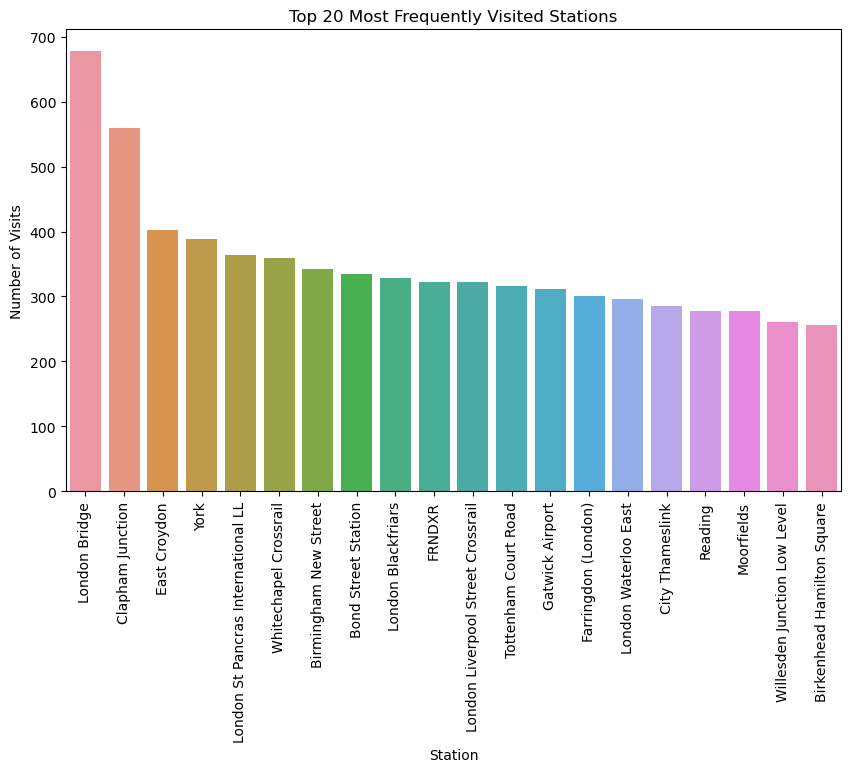

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

In [67]:
df_merged.describe()

,duration (min),Latitude,Longitude
count,93937.000000,89750.000000,89750.000000
mean,1.396229,52.368514,-1.233831
std,2.690991,1.469666,1.507773
min,0.200000,50.148339,-5.839077
25%,0.500000,51.452024,-2.447073
50%,1.000000,51.568037,-0.481390
75%,1.000000,53.360611,-0.081300
max,128.500000,58.513622,1.715711


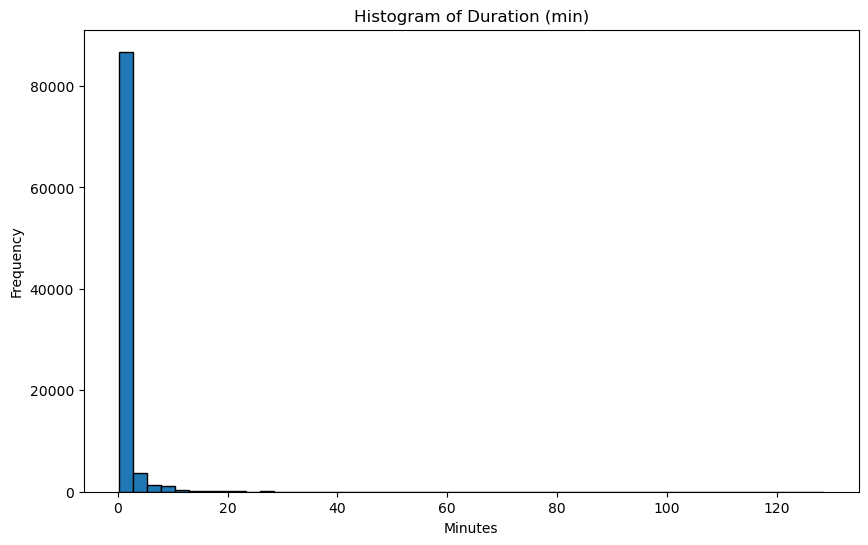

In [68]:
# Histogram for 'duration (min)'
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=50, edgecolor='black')
plt.title('Histogram of Duration (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

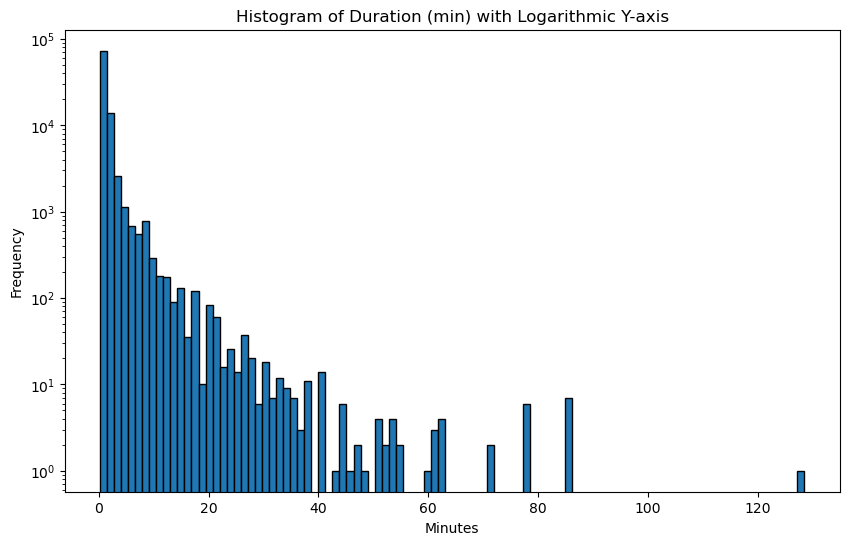

In [69]:
# Histogram for 'duration (min)' with smaller bins and logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black', log=True)

plt.title('Histogram of Duration (min) with Logarithmic Y-axis')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

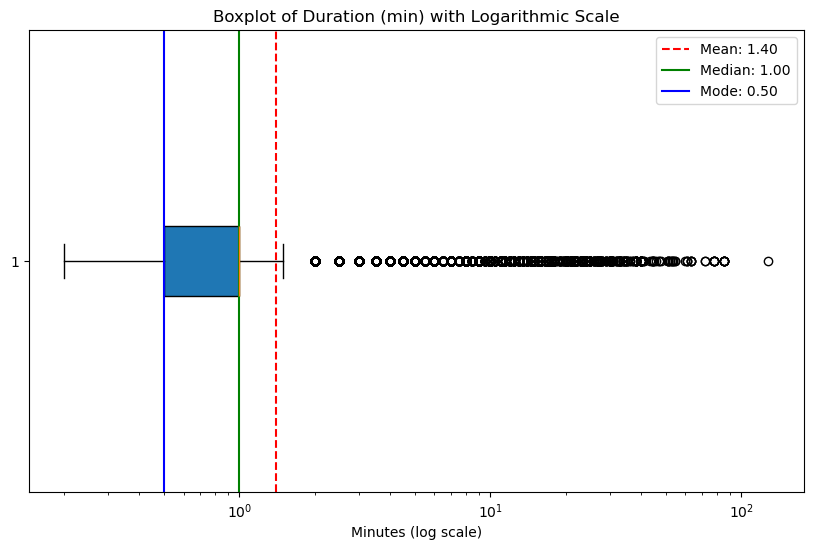

In [70]:
# Boxplot for 'duration (min)' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.boxplot(df_merged['duration (min)'], vert=False, patch_artist=True, showfliers=True)
plt.xscale('log')

# Add mean and median lines
mean_duration = df_merged['duration (min)'].mean()
median_duration = df_merged['duration (min)'].median()
mode_duration = df_merged['duration (min)'].mode().iloc[0]

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.2f}')
plt.axvline(median_duration, color='g', linestyle='-', label=f'Median: {median_duration:.2f}')
plt.axvline(mode_duration, color='b', linestyle='-', label=f'Mode: {mode_duration:.2f}')

plt.title('Boxplot of Duration (min) with Logarithmic Scale')
plt.xlabel('Minutes (log scale)')
plt.legend()
plt.show()

# Export Desired Dataframe

In [71]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')